# <span style='color:SteelBlue'>P6 - Segmentez des clients d'un site e-commerce</span>

**1- Missions**

Réaliser une première **étude de faisabilité** d'un moteur de **classification d'articles** basé sur une **image et une description** pour l'**automatisation** de l'attribution de la **catégorie de l'article**.

**2- Objectifs**

- analyser le jeu de données,
- réaliser :
    - un prétraitement des images,
    - un prétraitement des descriptions des produits
    - une réduction de dimension, 
    - puis un clustering. 

La représentation graphique aidera à convaincre que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.



#### Import de bibliothèques:

In [93]:
import datetime
import time
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import manifold, decomposition
from sklearn.cluster import KMeans
from sklearn import preprocessing
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier


from tensorflow import keras
from keras.preprocessing.image import img_to_array, load_img, smart_resize
from sklearn.decomposition import NMF
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical



### Les fonctions:

In [94]:
def visualisation_clusters(proj, clusters_labels, titre):
    plt.figure(figsize=[25, 15])
    sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=clusters_labels, s=100, alpha=1, palette='Set1')
    plt.title(titre, fontsize=25)
    plt.legend(bbox_to_anchor=(1.05, 1), loc= 1,  fontsize=25)
    plt.show()

def calcul_metriques_clusters(dataframe, titre):

    " Calculate des métriques of clusters"
   
    valeur_reel = dataframe['CATEGORIE']
    valeur_pred = dataframe['clusters']
    score_ari = adjusted_rand_score(valeur_reel, valeur_pred)
   

    metrique_clusters = pd.DataFrame({
        'Type_donnees': [titre],
        'ARI': [score_ari],
       })
    return metrique_clusters

In [95]:
def affiche_repartition_par_clusters(clusters_labels):
    '''
    Affiche la répartition par cluster
    '''
    ax1 = plt.gca()
    my_series = pd.Series(clusters_labels).value_counts()
    data_vis = pd.DataFrame({'Clusters': my_series.index,'Nombre': my_series.values})
    data_vis = data_vis.sort_values(by='Clusters')
    # visualisation (barplot)
    sns.set_style('white')
    sns.barplot(x='Clusters', y='Nombre',data=data_vis, color='SteelBlue', ax=ax1)

    ax1.set_ylabel('Nombre)', fontsize=12)
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_title('Répartition par clusters', fontsize=14)
    plt.gcf().set_size_inches(6, 4)
    plt.grid(False)
    plt.show()

#### Read Data:

In [96]:
data = pd.read_csv('data_clean.csv')
data = data.drop(columns = ['Unnamed: 0'])
data.head(2)

,uniq_id,product_name,product_category_tree,image,description,brand,product_specifications,cat_depth,len_depth_,sub_cat 0,...,sub_cat 4,sub_cat 5,sub_cat 6,description_tokenize,product_name_tokenize,descr_token,description_lemma,product_name_lemmatisé,description_stemmer,product_name_lemma
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","['Home Furnishing ', ' Curtains & Accessories ...",3,Home Furnishing,...,NaN,NaN,NaN,"['key', 'features', 'elegance', 'polyester', '...","['elegance', 'polyester', 'multicolor', 'abstr...",key features of elegance polyester multicolor ...,key elegance polyester multicolor abstract eye...,elegance polyester multicolor abstract eyelet ...,key eleg polyest multicolor abstract eyelet do...,elegance polyester multicolor abstract eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","['Baby Care ', ' Baby Bath & Skin ', ' Baby Ba...",4,Baby Care,...,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",NaN,NaN,"['specifications', 'sathiyas', 'cotton', 'bath...","['sathiyas', 'cotton', 'bath', 'towel']",specifications of sathiyas cotton bath towel (...,specification cotton bath towel bath towel red...,sathiyas cotton bath towel,specif cotton bath towel bath towel red yellow...,cotton bath towel


In [97]:
data.columns

Index(['uniq_id', 'product_name', 'product_category_tree', 'image',
       'description', 'brand', 'product_specifications', 'cat_depth',
       'len_depth_', 'sub_cat 0', 'sub_cat 1', 'sub_cat 2', 'sub_cat 3',
       'sub_cat 4', 'sub_cat 5', 'sub_cat 6', 'description_tokenize',
       'product_name_tokenize', 'descr_token', 'description_lemma',
       'product_name_lemmatisé', 'description_stemmer', 'product_name_lemma'],
      dtype='object')

In [98]:
path = 'Images/'
data['image_path'] = [path + image for image in data['image']]


* pour le traitement d'image on a besoin de :
   * image
   * image_path
   * sub_cat 0

In [99]:
my_data = data[['image', 'image_path', 'sub_cat 0']]
my_data.head()

,image,image_path,sub_cat 0
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


### Transfert learning CNN:

* Pour la présentation des clusters par kmeans nous allons extrait des caractéristiques des images pour obtenir une representation numérique de haut dimension, qui capture des informations importantes contenues dans des images.qui est généralement representé par une matrice de pixel.

* VGG16 : VGG16 est un modèle de réseau de neurones convolutifs profond (CNN) qui a été pré-entraîné sur de grandes quantités d'images pour la classification d'images dans 1000 classes différentes. Il utilise des convolutions et des couches entièrement connectées pour apprendre à extraire des caractéristiques de bas niveau (comme les bords, les textures) et de haut niveau (comme les formes, les objets) des images. Le modèle VGG16 est souvent utilisé dans le transfert d'apprentissage, où ses caractéristiques pré-apprises peuvent être utilisées pour d'autres tâches de vision par ordinateur, telles que la détection d'objets, la segmentation d'images, etc.

* Réduction de la dimensionnalité : La couche avant-dernière contient des caractéristiques de haut niveau, mais d'une dimensionnalité plus élevée, ce qui signifie que ces caractéristiques sont plus riches et potentiellement plus informatives que les sorties de la couche finale qui sont destinées à la classification en 1000 classes. Cela permet de conserver plus d'informations tout en réduisant la complexité du modèle.
ressource de Kaggle

In [100]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

* On fait la preparation des images et puis en fait la prediction des images avec le model préentrainé.

In [66]:
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


c:\Python38\lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

### Réduction de dimenssion:
* Données extraites a partir de modèl preentrainé sur les images préparée.
   

    * PCA

In [101]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)# garder 99% de componente.
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


* On passe de 4096 features à 803 features avec pca, 
* on va faire la visualisation en tsne et puis faire la prediction  par le kmeans.

* `TSNE et ACP:`

In [102]:
time_start = time.time()
tsne_vgg16 = TSNE(verbose = 1, perplexity = 30, n_iter = 1000, random_state = 20)
tsne_proj = tsne_vgg16.fit_transform(feat_pca)
duration = time.time() - time_start
dataframe_tsne = pd.DataFrame()
dataframe_tsne['VAR1'] = tsne_proj[:, 0]
dataframe_tsne['VAR2'] = tsne_proj[:, 1]
dataframe_tsne['CATEGORIE'] = data['sub_cat 0'] 
print(f"La durée de TSNE est : {duration}")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.003s...
[t-SNE] Computed neighbors for 1050 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 28.647482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.418694
[t-SNE] KL divergence after 1000 iterations: 1.016130
La durée de TSNE est : 3.8968665599823


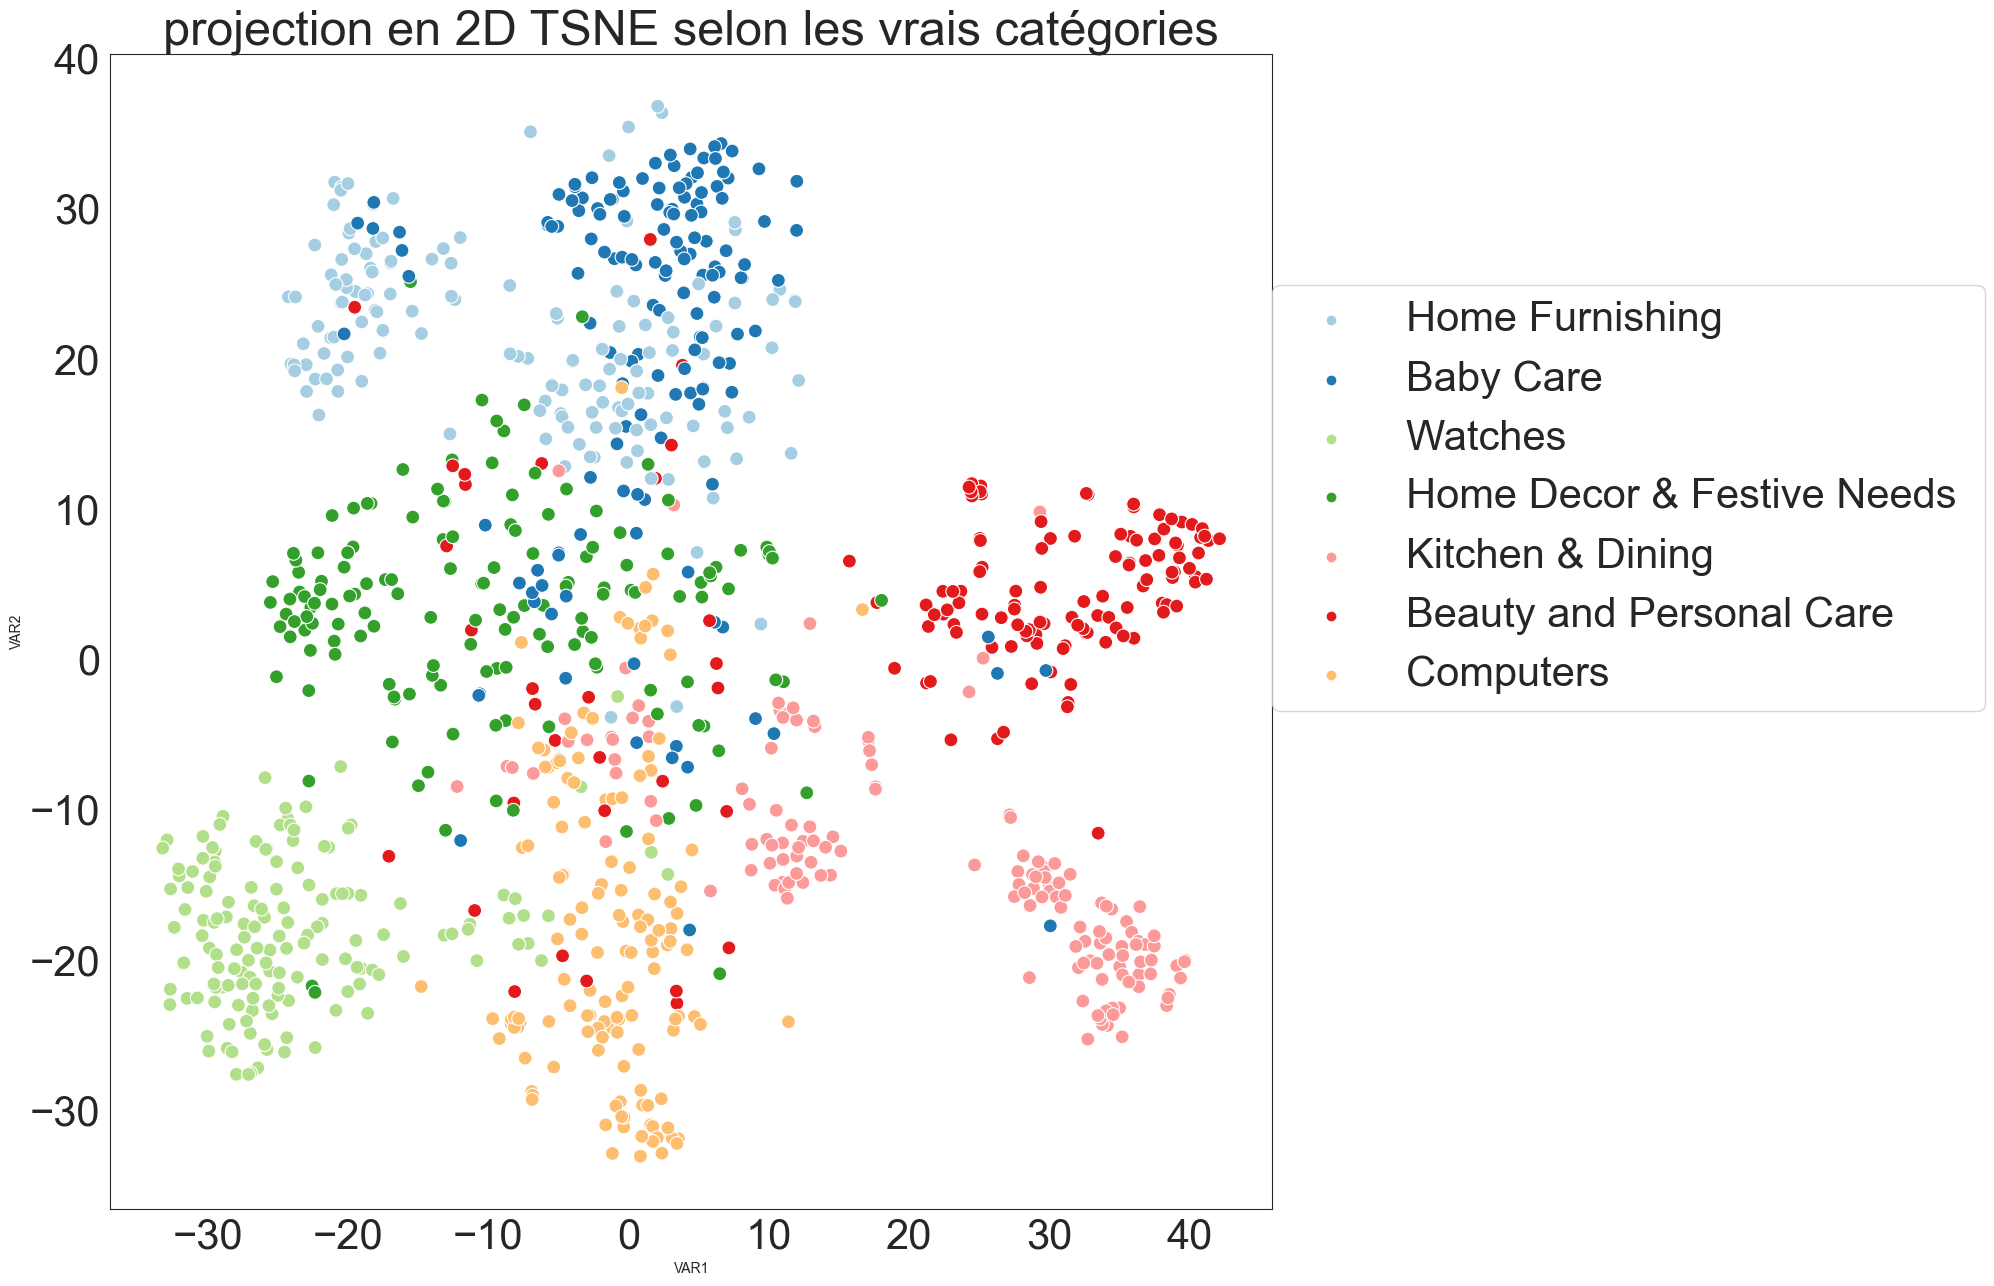

In [103]:
plt.figure(figsize=[15, 15])
sns.set_palette('Paired')
sns.scatterplot(x='VAR1', y='VAR2', data=dataframe_tsne, hue='CATEGORIE',s=100, alpha=1)
plt.legend(bbox_to_anchor=(1, 0.8), loc=2, borderaxespad=0., fontsize=30)
plt.title("projection en 2D TSNE selon les vrais catégories", fontsize = 35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(False)
plt.show()

* Avec la combinaison (vgg16 et tsne apres la réduction de dimentionalitée par pca et 
d'apres la visualisation , on peux séparer les produits de chaque catégories .
* On vois déja une séparation de catégories.)

##### clustering:
  -KMeans:

In [104]:
cols = ['VAR1','VAR2']
kmeans_tsne_vgg16 = KMeans(n_clusters=7, max_iter = 100,random_state = 42, n_init = 10)
kmeans_tsne_vgg16.fit(dataframe_tsne[cols])
dataframe_tsne['clusters'] = kmeans_tsne_vgg16.labels_
kmeans_tsne_vgg16_labels =  kmeans_tsne_vgg16.labels_

In [108]:
metriques = calcul_metriques_clusters(dataframe_tsne, 'ari_tsne_vgg16')
metriques

,Type_donnees,ARI
0,ari_tsne_vgg16,0.453973


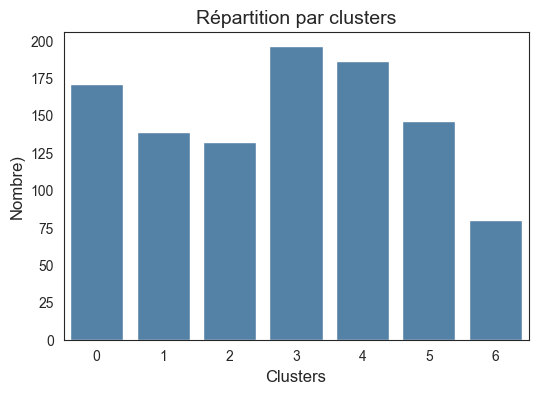

In [110]:
affiche_repartition_par_clusters(kmeans_tsne_vgg16_labels)

In [111]:
# Les catégories par clusters
dataframe_tsne.groupby('clusters')['CATEGORIE'].value_counts().to_frame()

count
clusters CATEGORIE                         
0        Computers                      113
         Kitchen & Dining                31
         Watches                         13
         Beauty and Personal Care         8
         Home Decor & Festive Needs       5
         Baby Care                        1
1        Home Furnishing                 67
         Home Decor & Festive Needs      58
         Baby Care                        8
         Beauty and Personal Care         6
2        Beauty and Personal Care       117
         Kitchen & Dining                10
         Baby Care                        3
         Home Decor & Festive Needs       1
         Computers                        1
3        Baby Care                      109
         Home Furnishing                 79
         Beauty and Personal Care         4
         Home Decor & Festive Needs       2
         Kitchen & Dining                 1
         Computers                        1
4        Home Decor & Festive Needs      76
         Computers                       34
         Kitchen & Dining                30
         Baby Care                       27
         Beauty and Personal Care        13
         Home Furnishing                  4
         Watches                          2
5        Watches                        135
         Home Decor & Festive Needs       8
         Baby Care                        1
         Beauty and Personal Care         1
         Computers                        1
6        Kitchen & Dining                78
         Baby Care                        1
         Beauty and Personal Care         1

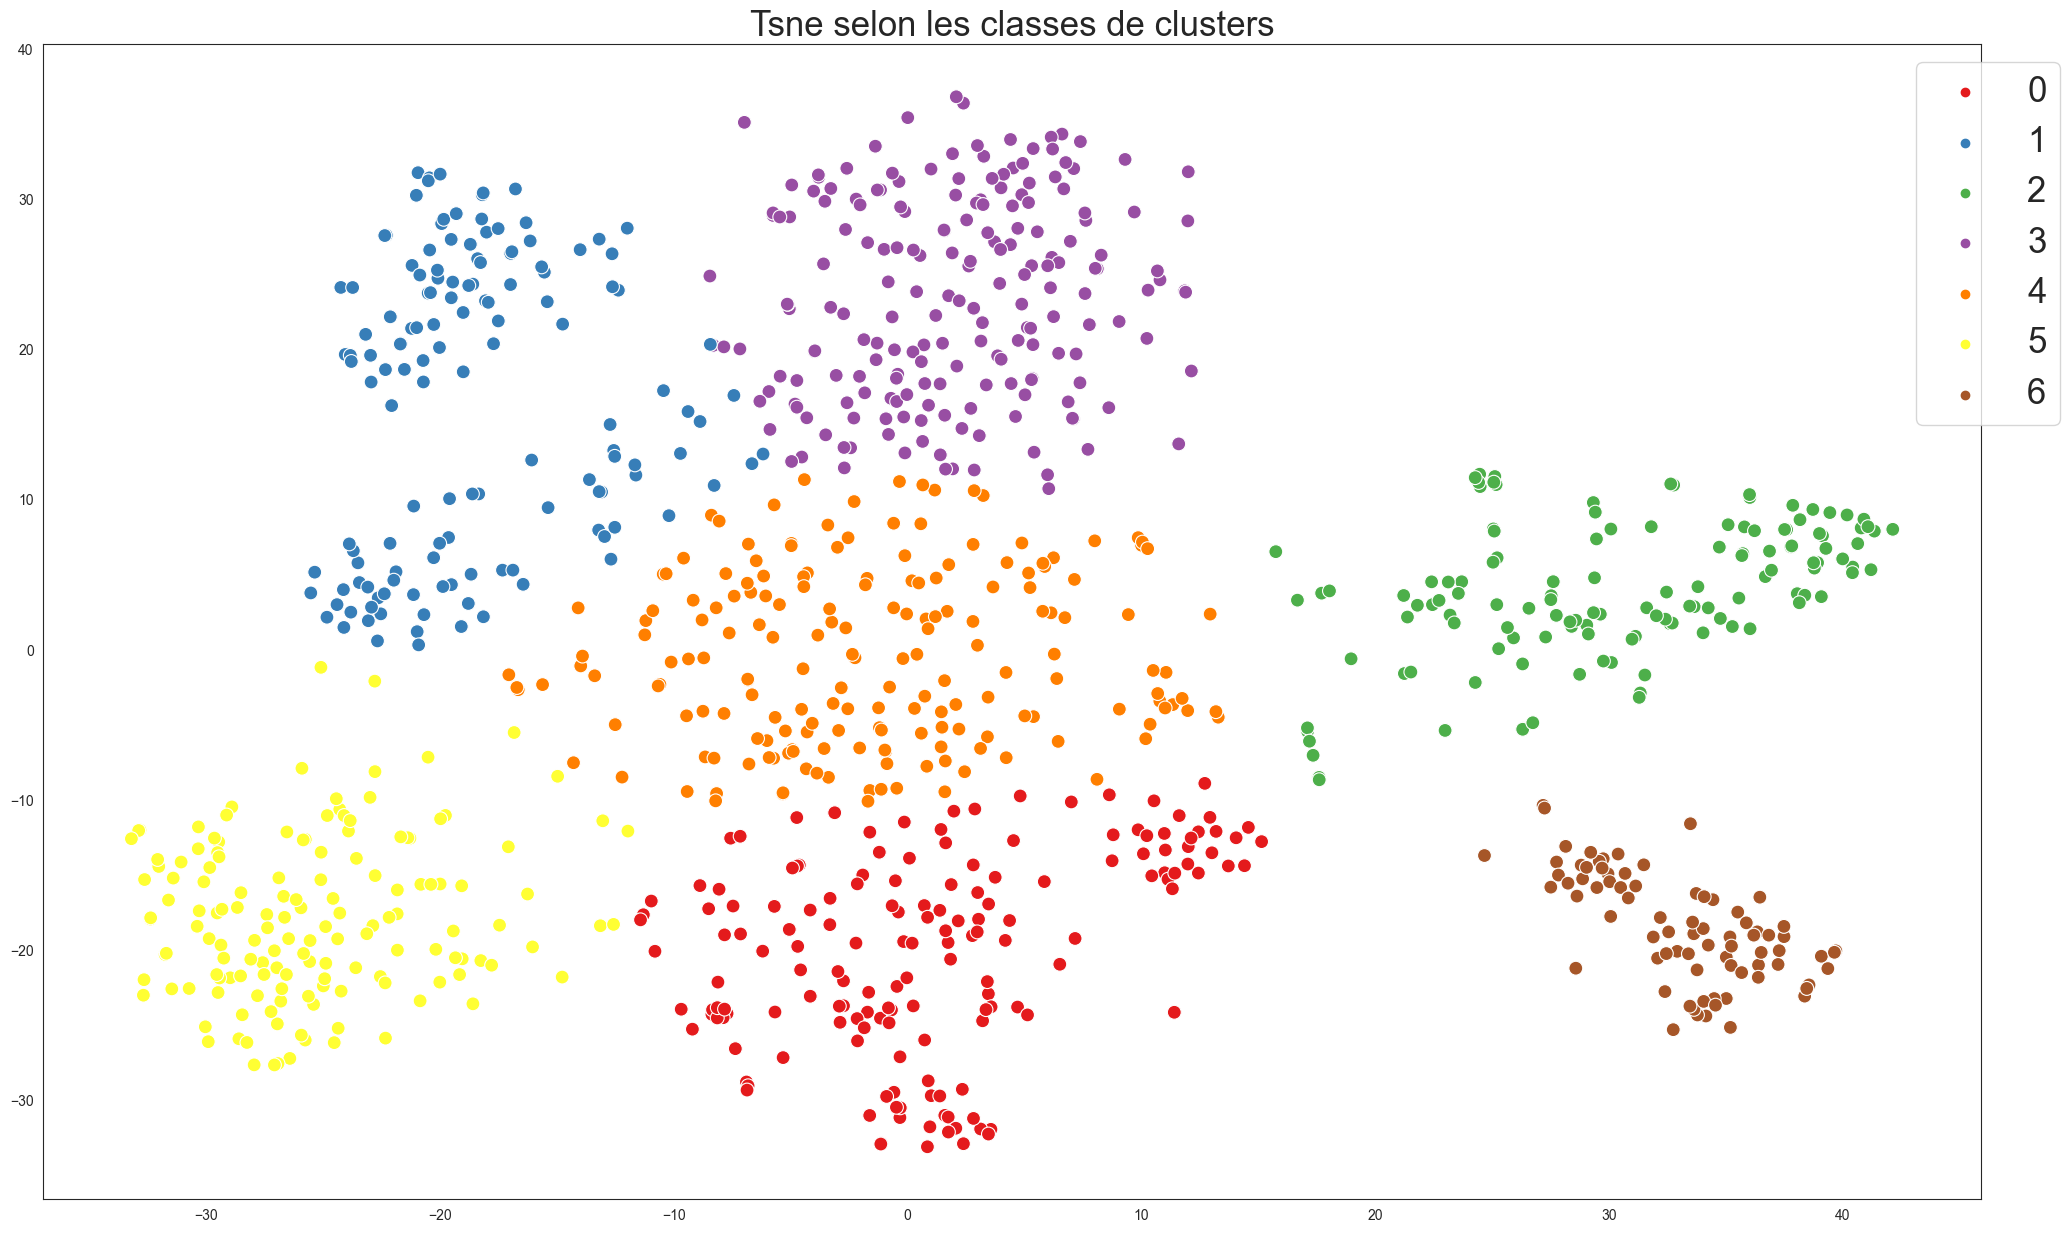

In [113]:
visualisation_clusters(tsne_proj,kmeans_tsne_vgg16_labels,'Tsne selon les classes de clusters')

In [116]:
dict = {'Type_donnees' : "tsne_sift",
        'ARI':0.05}

datametriques = pd.DataFrame([dict])
datametriques
metriques_ari = pd.concat([datametriques,metriques])
metriques_ari

,Type_donnees,ARI
0,tsne_sift,0.050000
0,ari_tsne_vgg16,0.453973


#### Bilan d'analyse:
************
* Avec la combinaison tsne et vgg16 le score ARI est à 0.45, c'est un bon score en comparant avec celui de sift, cette combinaison arrive à trouver les 7 catégories comme souhaite notre client.
*******

In [117]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(data["sub_cat 0"])
y

array([4, 0, 0, ..., 0, 0, 0])

In [118]:
y_true = data['sub_cat 0']
y_pred = kmeans_tsne_vgg16_labels 

In [119]:
from sklearn import cluster, metrics
conf_mat = metrics.confusion_matrix(y, y_pred)
print(conf_mat)

[[  1   8   3 109  27   1   1]
 [  8   6 117   4  13   1   1]
 [113   0   1   1  34   1   0]
 [  5  58   1   2  76   8   0]
 [  0  67   0  79   4   0   0]
 [ 31   0  10   1  30   0  78]
 [ 13   0   0   0   2 135   0]]


In [120]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [121]:
cls_labels_transform = conf_mat_transform(y, y_pred)
conf_mat = metrics.confusion_matrix(y, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(y, cls_labels_transform))

Correspondance des clusters :  [2 4 1 0 3 6 5]
[[109   3   1  27   8   1   1]
 [  4 117   8  13   6   1   1]
 [  1   1 113  34   0   0   1]
 [  2   1   5  76  58   0   8]
 [ 79   0   0   4  67   0   0]
 [  1  10  31  30   0  78   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.56      0.73      0.63       150
           1       0.89      0.78      0.83       150
           2       0.66      0.75      0.70       150
           3       0.41      0.51      0.45       150
           4       0.48      0.45      0.46       150
           5       0.97      0.52      0.68       150
           6       0.92      0.90      0.91       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



Text(0.5, 1.0, 'TSNE_VGG16')

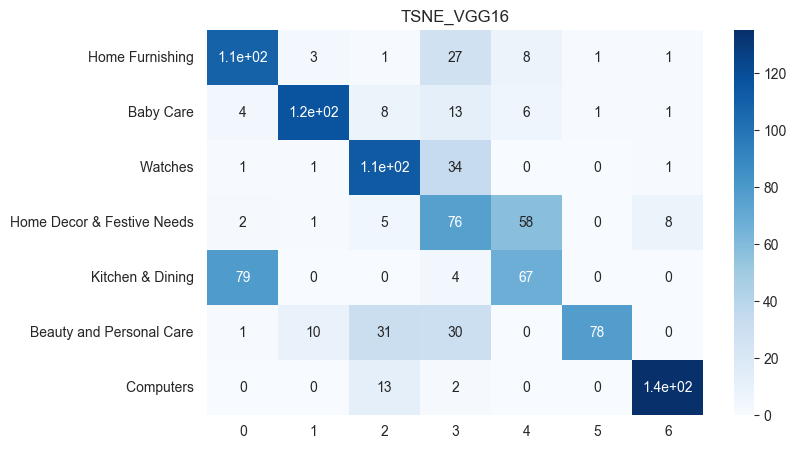

In [122]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data['sub_cat 0'].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("TSNE_VGG16")

#### Bilan d'analyse:
*********************
Cette combinaison arrive a trouver les 7 categories comme notre clients souhaite cepondant avec quelque mélange, le score ari est à 0.46,
les categories sont:
* clusters 0 :<<<<Home Decor & Festive Needs>>>> 
* clusters 1 :<<<< Beauty and Personal Care >>>> 
* clusters 2 :<<<< Watches >>>> 
* clusters 3 :<<<< Baby Care >>>> 
* clusters 4 :<<<< Computers >>>> 
* clusters 5 :<<<< Home Furnishing >>>> 
* clusters 6 :<<<< Kitchen & Dining >>>> 



*******************

### Classification supervisée:

* Données features vgg16()

In [124]:
dataframe_tsne["label"] = le.fit_transform(dataframe_tsne['CATEGORIE'])
my_data = dataframe_tsne[['VAR1','VAR2']]

In [125]:
seed = 33
testsize = 0.2
X_train, X_test, y_train, y_test = train_test_split(my_data, dataframe_tsne['label'], 
                                                    test_size=testsize, random_state=seed, shuffle=True, stratify=dataframe_tsne['label'])

In [126]:
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
y_train_clf = kn.predict(X_train)
y_test_clf = kn.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

0.8595238095238096 0.8476190476190476


In [ ]:
metrics_acuracy = pd.read_csv('metriques_sift_clf_supervisée.csv')


In [ ]:
dct = {'accuracy_train' :train_score,
        'accuracy_test': test_score,
        'Modeles': 'KNeighborsClassifier_VGG16_tsne'}
clf_suppervisée = metrics_acuracy.append([dct])
clf_suppervisée

In [129]:
cls_labels_transform = conf_mat_transform(y_test, y_test_clf)
cls_labels_transform = conf_mat_transform(y_test,y_test_clf)
conf_mat = metrics.confusion_matrix(y_test, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_test, cls_labels_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[21  0  0  1  7  1  0]
 [ 0 24  2  2  0  1  1]
 [ 0  0 29  1  0  0  0]
 [ 4  2  1 22  0  1  0]
 [ 2  0  0  1 27  0  0]
 [ 0  1  3  1  0 25  0]
 [ 0  0  0  0  0  0 30]]

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        30
           1       0.89      0.80      0.84        30
           2       0.83      0.97      0.89        30
           3       0.79      0.73      0.76        30
           4       0.79      0.90      0.84        30
           5       0.89      0.83      0.86        30
           6       0.97      1.00      0.98        30

    accuracy                           0.85       210
   macro avg       0.85      0.85      0.85       210
weighted avg       0.85      0.85      0.85       210



Text(0.5, 1.0, 'TSNE_VGG16_KNeighborsClassifier')

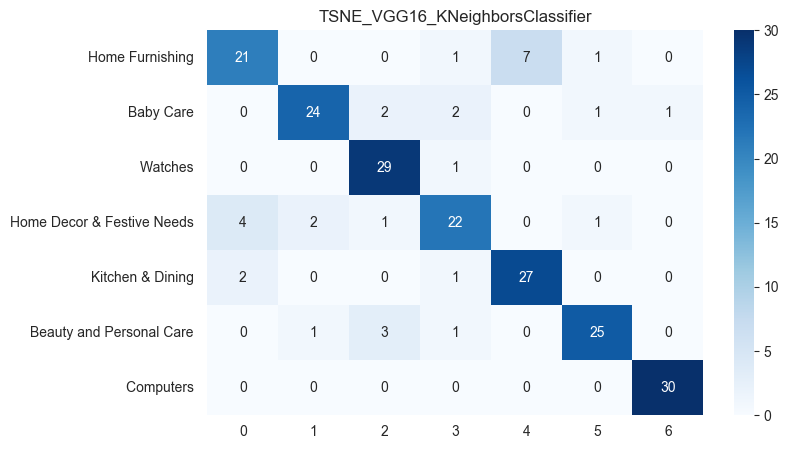

In [130]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data['sub_cat 0'].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("TSNE_VGG16_KNeighborsClassifier")

### Random forest classifier()

In [131]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_train_clf = rfc.predict(X_train)
y_test_clf = rfc.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

1.0 0.8142857142857143


In [132]:
dct = {'accuracy_train' :train_score,
        'accuracy_test': test_score,
        'Modeles': 'TSNE_VGG16_Randomforestclassifier'}
clf_suppervisée =clf_suppervisée.append([dct])
clf_suppervisée

NameError: name 'clf_suppervisée' is not defined

In [133]:
cls_labels_transform = conf_mat_transform(y_test, y_test_clf)
cls_labels_transform = conf_mat_transform(y_test,y_test_clf)
conf_mat = metrics.confusion_matrix(y_test, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_test, cls_labels_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[15  1  0  4  9  1  0]
 [ 2 24  2  1  0  0  1]
 [ 0  0 27  1  0  1  1]
 [ 2  1  1 25  0  1  0]
 [ 3  0  0  1 26  0  0]
 [ 0  1  3  0  2 24  0]
 [ 0  0  0  0  0  0 30]]

              precision    recall  f1-score   support

           0       0.68      0.50      0.58        30
           1       0.89      0.80      0.84        30
           2       0.82      0.90      0.86        30
           3       0.78      0.83      0.81        30
           4       0.70      0.87      0.78        30
           5       0.89      0.80      0.84        30
           6       0.94      1.00      0.97        30

    accuracy                           0.81       210
   macro avg       0.81      0.81      0.81       210
weighted avg       0.81      0.81      0.81       210



Text(0.5, 1.0, 'TSNE_VGG16_Randomforestclassifier')

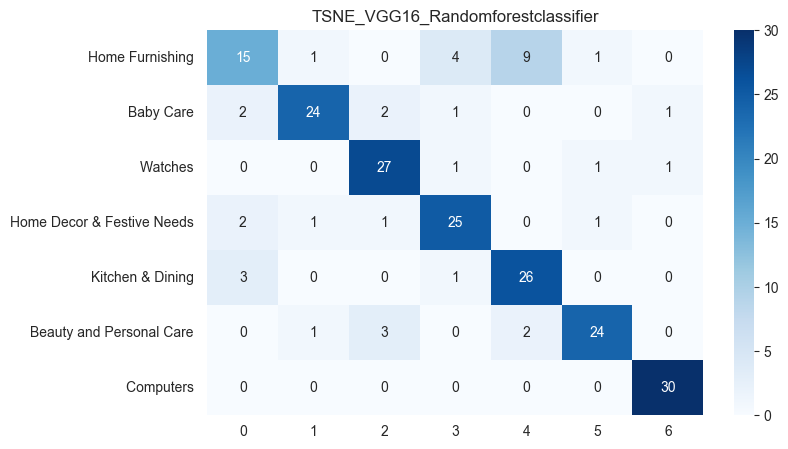

In [134]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data['sub_cat 0'].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("TSNE_VGG16_Randomforestclassifier")

### SVC()

In [135]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
y_train_clf = clf.predict(X_train)
y_test_clf = clf.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

0.7904761904761904 0.8333333333333334


In [136]:
dct = {'accuracy_train' :train_score,
        'accuracy_test': test_score,
        'Modeles': 'TSNE_VGG16_SVC'}
clf_suppervisée =clf_suppervisée.append([dct])
clf_suppervisée

NameError: name 'clf_suppervisée' is not defined

In [137]:
cls_labels_transform = conf_mat_transform(y_test, y_test_clf)
cls_labels_transform = conf_mat_transform(y_test,y_test_clf)
conf_mat = metrics.confusion_matrix(y_test, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_test, cls_labels_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
Correspondance des clusters :  [0 1 2 3 4 5 6]
[[15  0  1  5  8  1  0]
 [ 0 23  3  2  0  1  1]
 [ 0  0 29  1  0  0  0]
 [ 0  1  0 29  0  0  0]
 [ 2  0  0  1 27  0  0]
 [ 0  1  4  1  0 24  0]
 [ 0  0  2  0  0  0 28]]

              precision    recall  f1-score   support

           0       0.88      0.50      0.64        30
           1       0.92      0.77      0.84        30
           2       0.74      0.97      0.84        30
           3       0.74      0.97      0.84        30
           4       0.77      0.90      0.83        30
           5       0.92      0.80      0.86        30
           6       0.97      0.93      0.95        30

    accuracy                           0.83       210
   macro avg       0.85      0.83      0.83       210
weighted avg       0.85      0.83      0.83       210



Text(0.5, 1.0, 'TSNE_VGG16_svc')

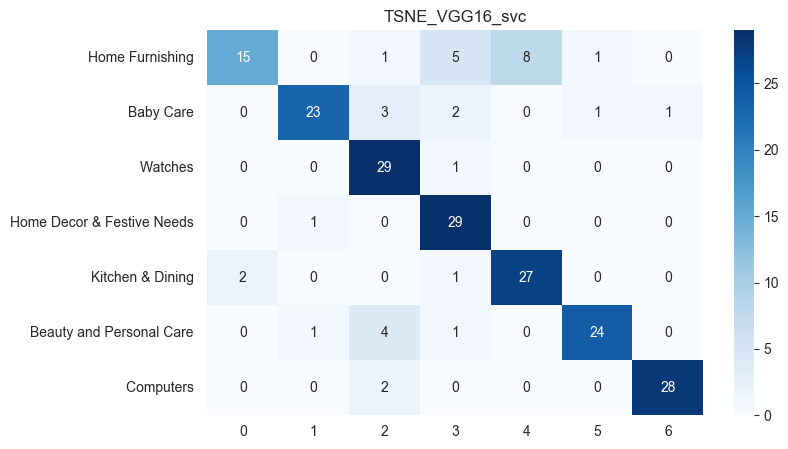

In [138]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data['sub_cat 0'].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("TSNE_VGG16_svc")

* Visualisation des metrics pour les differents modèles

In [ ]:
data_met

,Unnamed: 0,Type_donnees,ARI,Homogeneite,Completude,V-measure
0,0.0,TSNE_SIFT,0.055973,0.092455,0.093473,0.092961
0,NaN,vgg16_tsne,0.462000,0.550000,0.560000,0.555000


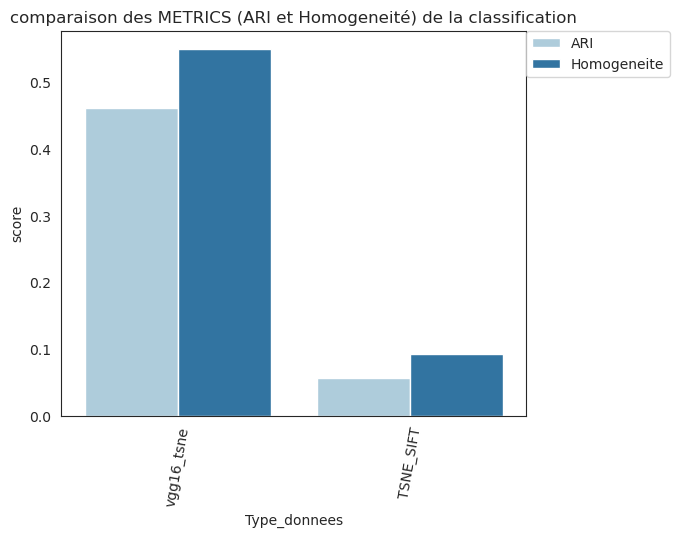

In [ ]:
nlp_metrics =data_met.sort_values(by = 'ARI', ascending = False)
metrics_nlp_melt = pd.melt(nlp_metrics, id_vars = ['Type_donnees'],
                                                    value_name = 'score',
                                                    value_vars = ['ARI','Homogeneite'])
plt.figure(figsize = (6,5))
sns.barplot(y = metrics_nlp_melt['score'] ,x = metrics_nlp_melt['Type_donnees'],
                                    hue = metrics_nlp_melt['variable'])
plt.xticks(rotation=80,fontsize=10)
plt.yticks(fontsize=10)

plt.title('comparaison des METRICS (ARI et Homogeneité) de la classification', fontsize=12)
plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0., fontsize=10)
plt.show()

In [ ]:
nlp_metrics =clf_suppervisée.sort_values(by = 'accuracy_train', ascending = False)
nlp_metrics

,Unnamed: 0,accuracy_train,accuracy_test,Modeles
1,0.0,1.000000,0.476190,Randomforest_clf_sift_tsne
0,NaN,1.000000,0.809524,TSNE_VGG16_Randomforestclassifier
0,NaN,0.861905,0.809524,KNeighborsClassifier_VGG16_tsne
0,NaN,0.796429,0.833333,TSNE_VGG16_SVC
0,0.0,0.576190,0.433333,KNeighborsClassifier_sift_tsne
2,0.0,0.375000,0.357143,SVC_sift_tsne


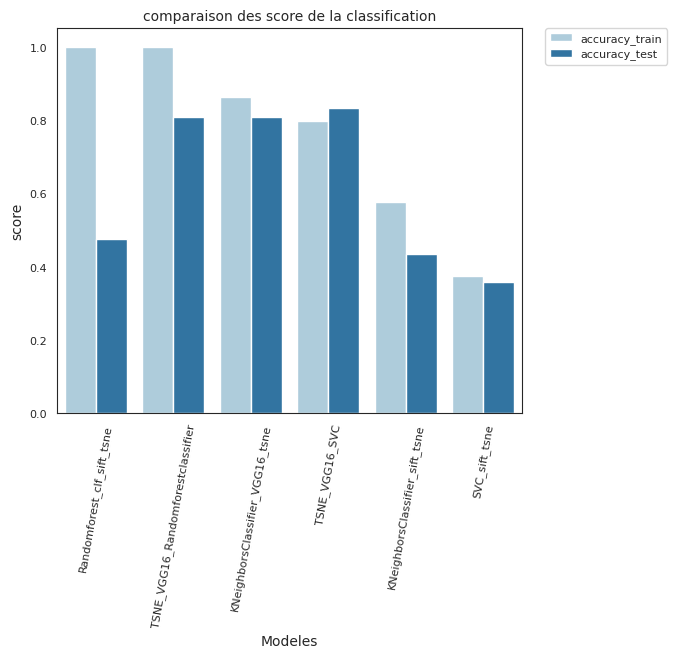

In [ ]:
nlp_metrics =clf_suppervisée.sort_values(by = 'accuracy_train', ascending = False)
metrics_nlp_melt = pd.melt(nlp_metrics, id_vars = ['Modeles'],
                                                    value_name = 'score',
                                                    value_vars = ['accuracy_train','accuracy_test'])
plt.figure(figsize = (6,5))
sns.barplot(y = metrics_nlp_melt['score'] ,x = metrics_nlp_melt['Modeles'],
                                    hue = metrics_nlp_melt['variable'])
plt.xticks(rotation=80,fontsize=8)
plt.yticks(fontsize=8)

plt.title('comparaison des score de la classification', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
plt.show()